# Methods and Parameters for Feature Detection: Part 1

In this notebook, we will take a detailed look at tobac's feature detection and examine some of its parameters. We concentrate on:

- [Minima/Maxima and Multiple Thresholds for Feature Identification](#Minima/Maxima-and-multiple-thresholds)
- [Feature Position](#Feature-Position)
- [Sigma Parameter for Smoothing of Noisy Data](#Sigma-Parameter-for-Smoothing-of-Noisy-Data)
- [Band Pass Filter for Input Fields](#Band-Pass-Filter-for-Input-Fields-via-Parameter-wavelength_filtering)


In [1]:
import tobac
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr

%matplotlib inline

import seaborn as sns

sns.set_context("talk")

## Minima/Maxima and Multiple Thresholds for Feature Identification

Feature identification search for local maxima in the data.

When working different inputs it is sometimes necessary to switch the feature detection from finding maxima to minima. Furthermore, for more complex datasets containing multiple features differing in magnitude, a categorization according to this magnitude is desirable. Both will be demonstrated with the `make_sample_data_2D_3blobs()` function, which creates such a dataset. For the search for minima we will simply turn the dataset negative:

In [2]:
data = tobac.testing.make_sample_data_2D_3blobs()
neg_data = -data

Let us have a look at frame number 50:

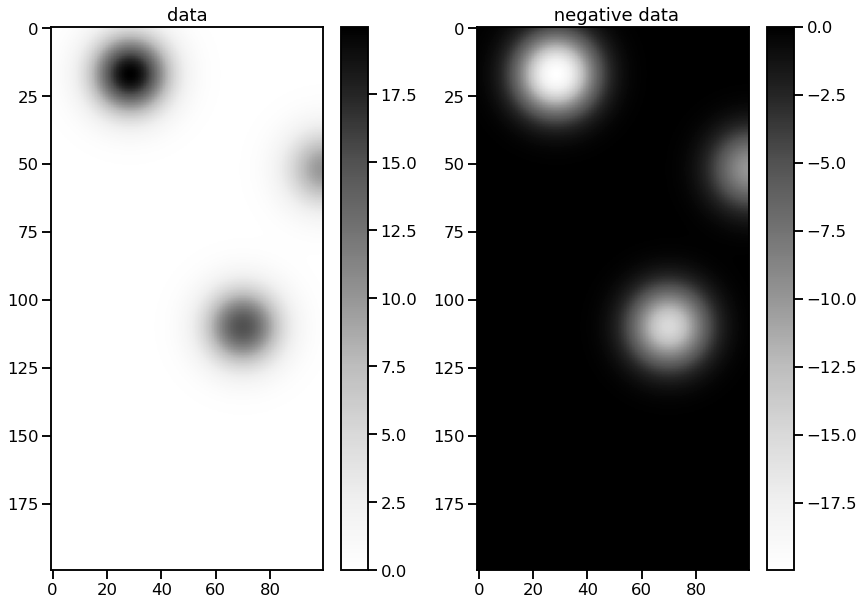

In [3]:
n = 50

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(14, 10))

im1 = ax1.imshow(data.data[50], cmap="Greys")
ax1.set_title("data")
cbar = plt.colorbar(im1, ax=ax1)

im2 = ax2.imshow(neg_data.data[50], cmap="Greys")
ax2.set_title(" negative data")
cbar = plt.colorbar(im2, ax=ax2)

As you can see the data has 3 maxima/minima with different extremal values. To capture these, we use list comprehensions to obtain multiple thresholds in the range of the data:

In [4]:
thresholds = [i for i in range(9, 18)]
neg_thresholds = [-i for i in range(9, 18)]

These can now be passed as arguments to `feature_detection_multithreshold()`. With the `target`-keyword we can set a flag whether to search for minima or maxima. The standard is `"maxima"`.

In [5]:
%%capture

dxy, dt = tobac.utils.get_spacings(data)

features = tobac.themes.tobac_v1.feature_detection_multithreshold(
    data, dxy, thresholds, target="maximum"
)
features_inv = tobac.themes.tobac_v1.feature_detection_multithreshold(
    neg_data, dxy, neg_thresholds, target="minimum"
)

Let's scatter the detected features onto frame 50  of the dataset and create colorbars for the threshold values:

Text(0, 0.5, 'threshold')

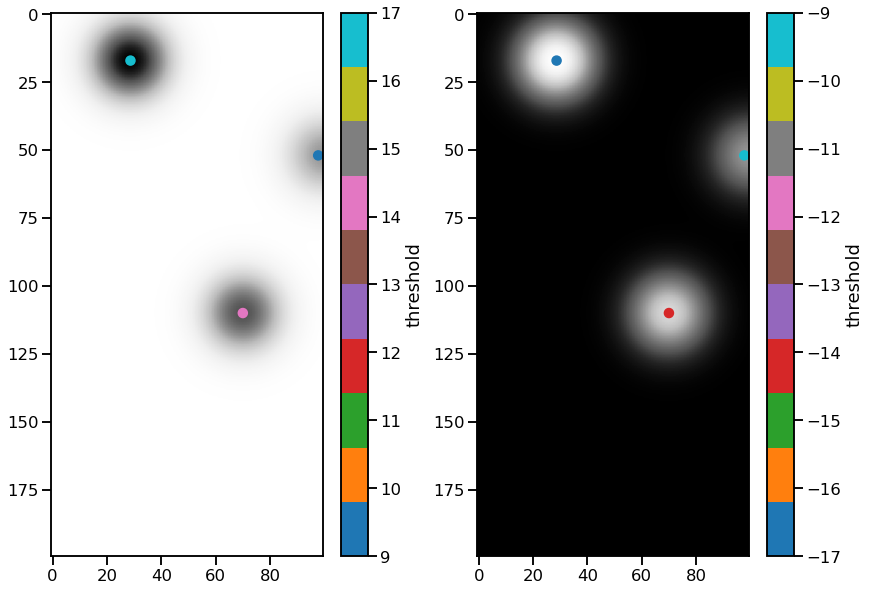

In [6]:
mask_1 = features["frame"] == n
mask_2 = features_inv["frame"] == n

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(14, 10))

ax1.imshow(data.data[50], cmap="Greys")
im1 = ax1.scatter(
    features.where(mask_1)["hdim_2"],
    features.where(mask_1)["hdim_1"],
    c=features.where(mask_1)["threshold_value"],
    cmap="tab10",
)
cbar = plt.colorbar(im1, ax=ax1)
cbar.ax.set_ylabel("threshold")

ax2.imshow(neg_data.data[50], cmap="Greys")
im2 = ax2.scatter(
    features_inv.where(mask_2)["hdim_2"],
    features_inv.where(mask_2)["hdim_1"],
    c=features_inv.where(mask_2)["threshold_value"],
    cmap="tab10",
)
cbar = plt.colorbar(im2, ax=ax2)
cbar.ax.set_ylabel("threshold")

The three features were found in both data sets, and the color bars indicate which threshold they belong to. When using multiple thresholds, note that the order of the list is important. Each feature is assigned the threshold value that was reached last. Therefore, it makes sense to start with the lowest value in case of maxima.

## Feature Position

To explore the influence of the `position_threshold` flag we need a radially asymmetric feature. Let's create a simple one by adding two 2d-gaussians and add an extra dimension for the time, which is required for working with tobac:

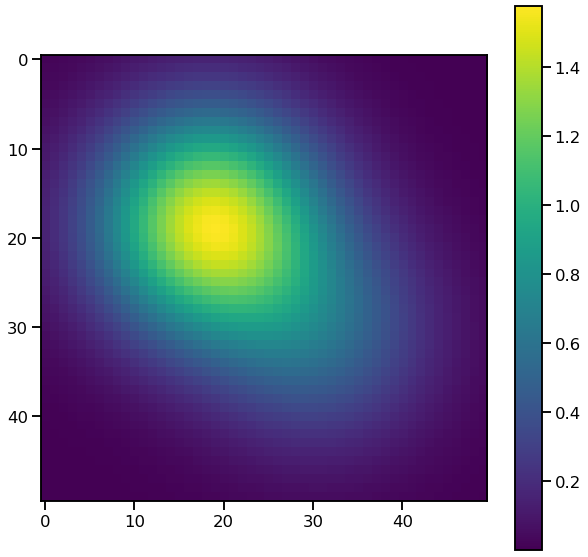

In [7]:
x = np.linspace(-2, 2)
y = np.linspace(-2, 2)
xx, yy = np.meshgrid(x, y)

exp1 = 1.5 * np.exp(-((xx + 0.5) ** 2 + (yy + 0.5) ** 2))
exp2 = 0.5 * np.exp(-((0.5 - xx) ** 2 + (0.5 - yy) ** 2))

asymmetric_data = np.expand_dims(exp1 + exp2, axis=0)

plt.figure(figsize=(10, 10))
plt.imshow(asymmetric_data[0])
plt.colorbar()

To feed this data into the feature detection we need to convert it into an `xarray.DataArray`. Before we do that we select an arbitrary time and date for the single frame of our synthetic field:

In [8]:
date = np.datetime64(
    "2022-04-01T00:00",
)
assym = xr.DataArray(
    data=asymmetric_data, coords={"time": np.expand_dims(date, axis=0), "y": y, "x": x}
)
assym

<xarray.DataArray (time: 1, y: 50, x: 50)>
array([[[0.01666536, 0.02114886, 0.02648334, ..., 0.00083392,
         0.00058509, 0.00040694],
        [0.02114886, 0.02683866, 0.03360844, ..., 0.00109464,
         0.00077154, 0.0005393 ],
        [0.02648334, 0.03360844, 0.04208603, ..., 0.00142435,
         0.00100896, 0.00070907],
        ...,
        [0.00083392, 0.00109464, 0.00142435, ..., 0.01405279,
         0.01121917, 0.00883872],
        [0.00058509, 0.00077154, 0.00100896, ..., 0.01121917,
         0.00895731, 0.00705704],
        [0.00040694, 0.0005393 , 0.00070907, ..., 0.00883872,
         0.00705704, 0.00556009]]])
Coordinates:
  * time     (time) datetime64[ns] 2022-04-01
  * y        (y) float64 -2.0 -1.918 -1.837 -1.755 ... 1.755 1.837 1.918 2.0
  * x        (x) float64 -2.0 -1.918 -1.837 -1.755 ... 1.755 1.837 1.918 2.0

Since we do not have a dt in this dataset, we can not use the `get_spacings()`-utility this time and need to calculate the `dxy` spacing manually:

In [9]:
dxy = assym.diff("x")

Finally, we choose a threshold in the datarange and apply the feature detection with the four `position_threshold` flags
- 'center' 
- 'extreme'
- 'weighted_diff'
- 'weighted_abs'

In [10]:
%%capture

threshold = 0.2
features_center = tobac.themes.tobac_v1.feature_detection_multithreshold(
    assym, dxy, threshold, position_threshold="center"
)
features_extreme = tobac.themes.tobac_v1.feature_detection_multithreshold(
    assym, dxy, threshold, position_threshold="extreme"
)
features_diff = tobac.themes.tobac_v1.feature_detection_multithreshold(
    assym, dxy, threshold, position_threshold="weighted_diff"
)
features_abs = tobac.themes.tobac_v1.feature_detection_multithreshold(
    assym, dxy, threshold, position_threshold="weighted_abs"
)

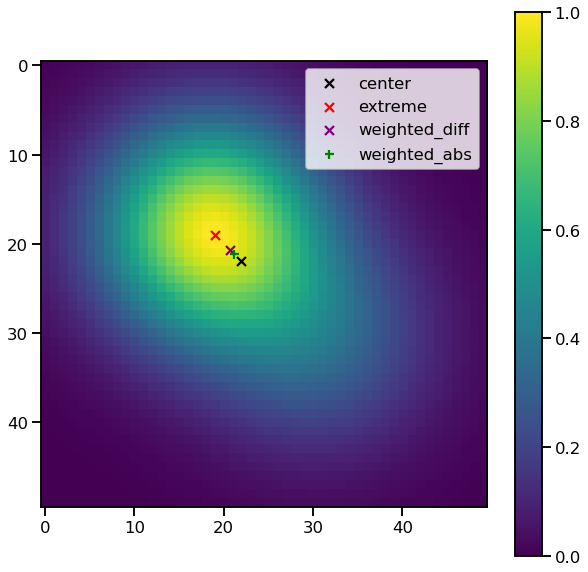

In [11]:
plt.figure(figsize=(10, 10))
plt.imshow(assym[0])
plt.scatter(
    features_center["hdim_2"],
    features_center["hdim_1"],
    color="black",
    marker="x",
    label="center",
)
plt.scatter(
    features_extreme["hdim_2"],
    features_extreme["hdim_1"],
    color="red",
    marker="x",
    label="extreme",
)
plt.scatter(
    features_diff["hdim_2"],
    features_diff["hdim_1"],
    color="purple",
    marker="x",
    label="weighted_diff",
)
plt.scatter(
    features_abs["hdim_2"],
    features_abs["hdim_1"],
    color="green",
    marker="+",
    label="weighted_abs",
)
plt.colorbar()
plt.legend()

As you can see this parameter specifies how the postion of the feature is defined. These are the descriptions given in the [code](https://github.com/tobac-project/tobac/blob/v2.0-dev/tobac/themes/tobac_v1/feature_detection.py):

- extreme:       get position as max/min position inside the identified region
- center :       get position as geometrical centre of identified region
- weighted_diff: get position as centre of identified region, weighted by difference from the threshold
- weighted_abs:  get position as centre of identified region, weighted by absolute values if the field

## Sigma Parameter for Smoothing of Noisy Data

Before the features are searched a gausian filter is applied to the data in order to smooth it. So let's import the filter used by tobac for a demonstration:

In [12]:
from scipy.ndimage import gaussian_filter

This filter works performing a convolution of a (in our case 2-dimensional) gaussian function

$$
h(x, y) = \frac{1}{2 \pi \sigma^2} \exp \left( - \frac{x^2+y^2}{2 \sigma^2} \right)
$$

with our data and with this parameter we set the value of $\sigma$.

The effect of this filter can best be demonstrated on very sharp edges in the input. Therefore we create an array from a boolean mask of another 2d-Gaussian, which has only values of 0 or 1:

In [13]:
x = np.linspace(-2, 2)
y = np.linspace(-2, 2)
xx, yy = np.meshgrid(x, y)

exp = np.exp(-(xx**2 + yy**2))

gaussian_data = np.expand_dims(exp, axis=0)

and we add some random noise to it:

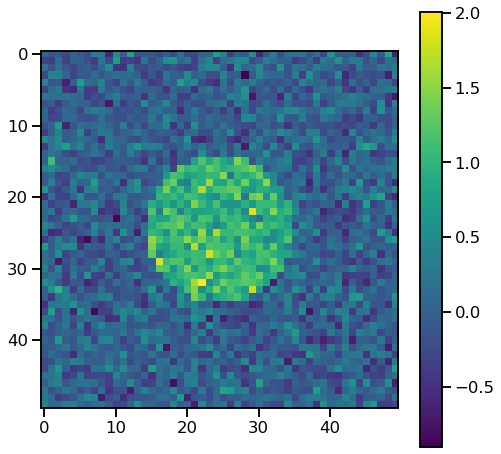

In [14]:
noise = 0.3 * np.random.randn(*gaussian_data.shape)
data_sharp = np.array(gaussian_data > 0.5, dtype="float32")

data_sharp += noise

plt.figure(figsize=(8, 8))
plt.imshow(data_sharp[0])
plt.colorbar()

If we apply this filter to the data with increasing sigmas, increasingly smoothed data will be the result:

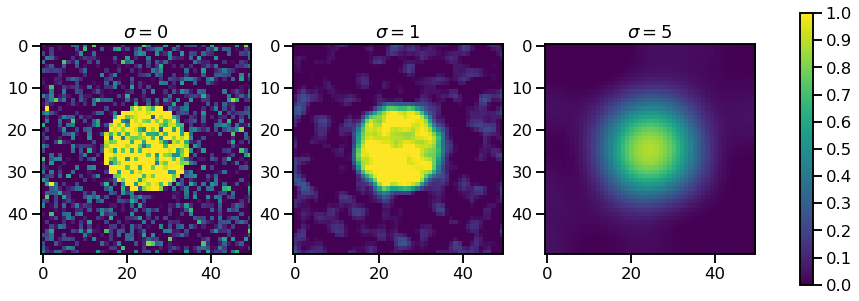

In [15]:
non_smooth_data = gaussian_filter(data_sharp, sigma=0)
smooth_data = gaussian_filter(data_sharp, sigma=1)
smoother_data = gaussian_filter(data_sharp, sigma=5)

fig, axes = plt.subplots(ncols=3, figsize=(16, 10))

im0 = axes[0].imshow(non_smooth_data[0], vmin=0, vmax=1)
axes[0].set_title(r"$\sigma = 0$")

im1 = axes[1].imshow(smooth_data[0], vmin=0, vmax=1)
axes[1].set_title(r"$\sigma = 1$")

im2 = axes[2].imshow(smoother_data[0], vmin=0, vmax=1)
axes[2].set_title(r"$\sigma = 5$")

cbar = fig.colorbar(im1, ax=axes.tolist(), shrink=0.5)
cbar.set_ticks(np.linspace(0, 1, 11))

This is what happens in the background, when the `feature_detection_multithreshold()` function is called. The default value of `sigma_threshold` is 0.5. The next step is trying to detect features of the dataset with these   `sigma_threshold` values. We first need an xarray DataArray again:

In [16]:
date = np.datetime64("2022-04-01T00:00")
input_data = xr.DataArray(
    data=data_sharp, coords={"time": np.expand_dims(date, axis=0), "y": y, "x": x}
)

Now we set a threshold and detect the features:

In [17]:
%%capture

threshold = 0.9
features_sharp = tobac.themes.tobac_v1.feature_detection_multithreshold(
    input_data, dxy, threshold, sigma_threshold=0
)
features_smooth = tobac.themes.tobac_v1.feature_detection_multithreshold(
    input_data, dxy, threshold, sigma_threshold=1
)
features_smoother = tobac.themes.tobac_v1.feature_detection_multithreshold(
    input_data, dxy, threshold, sigma_threshold=5
)

Attempting to plot the results

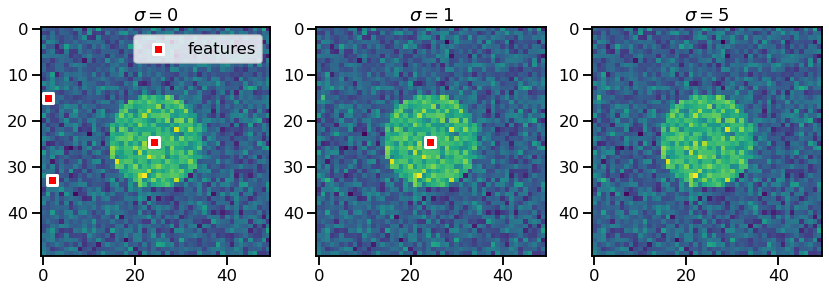

In [18]:
fig, axes = plt.subplots(ncols=3, figsize=(14, 10))
plot_kws = dict(
    color="red",
    marker="s",
    s=100,
    edgecolors="w",
    linewidth=3,
)

im0 = axes[0].imshow(input_data[0])
axes[0].set_title(r"$\sigma = 0$")
axes[0].scatter(
    features_sharp["hdim_2"], features_sharp["hdim_1"], label="features", **plot_kws
)
axes[0].legend()

im0 = axes[1].imshow(input_data[0])
axes[1].set_title(r"$\sigma = 1$")
axes[1].scatter(features_smooth["hdim_2"], features_smooth["hdim_1"], **plot_kws)

im0 = axes[2].imshow(input_data[0])
axes[2].set_title(r"$\sigma = 5$")
try:
    axes[2].scatter(
        features_smoother["hdim_2"], features_smoother["hdim_1"], **plot_kws
    )
except:
    print("WARNING: No Feature Detected!")

Noise may cause some false detections (left panel) that are significantly reduced when a suitable smoothing parameter is chosen (middle panel).

## Band-Pass Filter for Input Fields via Parameter `wavelength_filtering`

This parameter can be understood best, when looking at real instead of snythethic data. An example of usage is given [here](../Example_vorticity_tracking_model/Example_vorticity_tracking_model.ipynb)